Model Design Specification Document
Analysis of model options explored, the challenges and remedial steps taken

Overview:
Consider a content post d=string()
After tokenization, it appears as-
d=list(T(d))
This tokenized and cleansed text forms the basis of all three approaches explained below. So far 3 Options have been explored-

Option A:
Idea: Measure the occurrence of words that attributed to sub-topics of trust. The relative frequency of these words in a tweet along with the sentiment state defines the trust score
Approach:

1. Build a sub-topic bag of words(SBOW) for each sub-topic(synonyms, similar words based on human understanding of sub-topic)
2. In T(d), find the % of words that belong to SBOW for each sub-topic S.
3. Aggregate the value generated in step 2 using mean/weighted-mean to obtain trust score.

Challenges:
1. The content of SBOW for each S is relatively sparse(our SBOWs were <30 words)
2. A sparse SBOW leads to very small relative frequency.
3. Even if SBOW size is increased, semantic similarity cannot be associated to a heuristic approach like relative frequency.
4. Response values are also sparse given that the vocabulary/linguistics on social media platforms differs from standard English lexicon(choice of words, abbreviation, tone, level of formality, etc.).

To develop a better understanding of the subject matter being discussed in the sample data, we decided to follow an unsupervised approach to identify discussion topics and the word patterns in these topics.

Option B:
Idea: Using pre-processed content text ct=preprocess(T(d)), establish themes across clusters of topics that are prevalent in the sample data. Based on the term frequencies of repeated terms 'rt' in each topic, build a fuzzy relation between a sub-topic S and rt. The result is an enhanced SBOW upon which relative frequencies and/or semantic similarity can be measured
Approach:

1. Preprocess each content text ct. Add POS tag for each word w in ct
2. Apply LDA using gensim_models package on all w in all ct in the data set.
3. choose an arbitrary number of topics for clustering.
4. Obtain the top 30(arbitrary) words in each topic.
5. Establish a pattern between the terms with highest relative frequencies to deduce SBOW for each st.

Challenges:
1. The top 30 words for each topic in LDA were generic. Tuning the num_topics for each LDA did not improve the results
2. While the intent was to identify more trust-related terms out of the content, the noise levels were still so high that the trust related terms were not reflecting in the unsupervised topics generated by the model. Alternately, we inferred that trust-related or customer-service related talk was too low to be pulled up as a topic on its own.
3. To optimize the topic modeling, we performed all the steps separately for each POS type(noun, adjective, verb) to explore any new patterns in the data. The output still was oriented on generic themes(not trust-related).


Option C:
Idea: Convert word representations of each w in ct into vectors. Aggregate the vector for each ct. Based on labeled scores for Integrity, Transparency and Competency, build an SBOW that represents a theme( +ve or -ve) for each st. The semantic similarity between vectorized ct and SBOW of theme represents the predictor variable for each theme. Based on this representation, fit a regression model to fit a trust score for a given ct.

Approach:
1. Preprocess each content text ct and find word embeddings e for each word w in ct. Embeddings are vectorized representations of w in GloVe.
2. val=sum(e). val is intended to represent a text that is semantically similar to ct. Create a neighborhood of 200 terms(arbitrary) closest to val and store it in vn.
3. Theme th for a ct is known. For every ct belonging to th, find the intersect of all vals. This represents a BOW for th.
4. Thematic score for ct is TS=(Intersection of th BOW and vn)/(word count of ct). The value of each TS for each ct is a predictor variable.
5. Regress upon predictor variables TS and Y=trust score to fit a model

Status:
1. Response variable is available for 300 rows. Out of which ~150 have non-zero scores(trust-related conversations occurring).
2. Step 2 is currently in progress.

Opportunity with option C:
1. Quantifiable values can be generated for each theme.
2. The end goal of finding semantically similar text is a achievable through this approach. Only once the ratios for each theme is computed, we can have more clarity.

Potential gaps:
1. Need to reconfirm the logical interpretation of val.
2. TS in step 4 is heavily dependent on BOW size and content. If the words in BOW for each th have high semantic variance, the overlaps in BOW set and vn will be sparse or potentially disjoint sets.
3. GloVe Embedding computation code takes a large amount of time for each iteration due to high dimensionality of the matrix. Any re-computation significantly slows down the model design process.

Remedial steps:
1.	Mitigate the total effort by training the model on smaller sample set.
2.	Focus only on one theme/topic and then scale up to incorporate the trust score.
3.	Follow modular design for ease of scale and reusabilitiy.
4.  Optimize file read and high-dimensionality operations to reduce feature extraction time.

Steps of option c are broken down further in the markdown and code block comments as below-

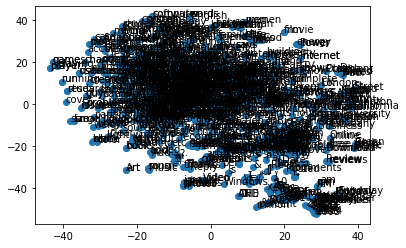

In [2]:
#original code. ignore this block
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

embeddings_dict = {}
with open("glove.840B.300d.txt", 'r', encoding="utf-8",errors='ignore') as f:
    for line in f:
        values = line.split( " ")
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]
Y = tsne.fit_transform(vectors[:1000])

plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()


Option C:
Idea: Convert word representations of each w in ct into vectors. Aggregate the vector for each ct. Based on labeled scores for Integrity, Transparency and Competency, build an SBOW that represents a theme( +ve or -ve) for each st. The semantic similarity between vectorized ct and SBOW of theme represents the predictor variable for each theme. Based on this representation, fit a regression model to fit a trust score for a given ct.



Approach:
Step 1. Preprocess each content text ct and find word embeddings e for each word w in ct. Embeddings are vectorized representations of w in GloVe.


In [3]:
import pandas as pd
import numpy as np
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
import string

#filepath='C:\\Users\\Dwarkesh\\Documents\\UC\\Summer\\BANA7095- Graduate Case Studies in Business Analytics\\Scoring\\Chase Bank Level 1.csv'
#score_file_path="C:\\Users\\Dwarkesh\\Documents\\UC\\Summer\\BANA7095- Graduate Case Studies in Business Analytics\\Data Analysis"

doc_df = pd.read_excel("Final_data_ITC_scores_Dwarkesh_Shaoni_Vedangini.xlsx")

import re

doc_df['content_text_processed'] =doc_df['content'].map(lambda x: re.sub('[,\.!?]', '', str(x)))
doc_df['content_text_processed'] = doc_df['content_text_processed'].map(lambda x: x.lower())
doc_df['content_text_processed'].head()

def tokenization(text):
    text = re.split('\W+', text)    
    return text
   # doc_df['Tweet_tokenized'] = doc_df['title_wo_punct'].apply(lambda x: tokenization(x.lower()))
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dwarkesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dwarkesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
doc_df = pd.read_excel("Final_data_ITC_scores_Dwarkesh_Shaoni_Vedangini.xlsx",sheet_name="Final_data_scores")
doc_df['content_text_processed'] =doc_df['content'].map(lambda x: re.sub('[,\.!?]', '', str(x)))
doc_df['content_text_processed'] = doc_df['content_text_processed'].map(lambda x: x.lower())
doc_df['content_text_processed'].head()

0    position overview at pnc our people are our gr...
1    “avg’s visionary management team has built a l...
2    our women’s conf kicks off tomorrow at 12pm wo...
3    operations analyst sr trust vault position ove...
4    easy mobile deposit user friendly app for othe...
Name: content_text_processed, dtype: object

In [6]:
def tokenization(text):
    text = re.split('\W+', text)    
    return text
   # doc_df['Tweet_tokenized'] = doc_df['title_wo_punct'].apply(lambda x: tokenization(x.lower()))


stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [124]:
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('Everything is all about money.')
def xyz(text):
    tokenized = sent_tokenize(text)
    tagged=''
    for i in tokenized:
        # Word tokenizers is used to find the words 
        # and punctuation in a string
        wordsList = nltk.word_tokenize(i)
        # removing stop words from wordList
        #wordsList = [w for w in wordsList if not w in stop_words] 
        #print (wordsList)

        #  Using a Tagger. Which is part-of-speech 
        # tagger or POS-tagger. 
        tagged = nltk.pos_tag(wordsList)

    return tagged


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dwarkesh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dwarkesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading Everything is all about money.: Package
[nltk_data]     'Everything is all about money.' not found in index


In [134]:
#Function declarations
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text


def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct


def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

def pre(df,col):
    df['title_wo_punct']=df[col].fillna(' ').apply(lambda x: remove_punctuation(x))
    if 'Unnamed: 0' in df.columns:
        df=df.drop(['Unnamed: 0'],axis=1)
    df['Tweet_tokenized'] = df['title_wo_punct'].apply(lambda x: tokenization(x.lower()))
    df['Tweet_nonstop'] = df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
    df['Tweet_stemmed'] = df['Tweet_nonstop'].apply(lambda x: stemming(x))
    df['pos_tag'] = df["content_text_processed"].map(lambda x: xyz(x))

    return df

#GloVe based functions
def find_closest_embeddings(embeddings_dict,embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))
def compute_content_embedding(embeddings_dict,content,n_close=100):
    val=np.zeros_like(embeddings_dict['king'])
    #print(val)
    for i in content:
        if i in embeddings_dict.keys():
            val+=embeddings_dict[i]
    content_sum=find_closest_embeddings(embeddings_dict,val)[:n_close]
    return content_sum

In [8]:
#Step 1 completed. head of new columns in the main dataframe

In [135]:
#main preprocessing and newly generated columns. Step 1 completed
doc_df = pre(doc_df,col='content')
doc_df.iloc[:,-6:].head()

,content_text_processed,title_wo_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed
0,position overview at pnc our people are our gr...,Position Overview At PNC our people are our gr...,"[position, overview, at, pnc, our, people, are...","[position, overview, pnc, people, greatest, di...","[posit, overview, pnc, peopl, greatest, differ..."
1,“avg’s visionary management team has built a l...,“AVG’s visionary management team has built a l...,"[, avg, s, visionary, management, team, has, b...","[, avg, visionary, management, team, built, le...","[, avg, visionari, manag, team, built, lead, v..."
2,our women’s conf kicks off tomorrow at 12pm wo...,Our Women’s Conf kicks off tomorrow at 12pm Wo...,"[our, women, s, conf, kicks, off, tomorrow, at...","[women, conf, kicks, tomorrow, 12pm, women, wo...","[women, conf, kick, tomorrow, 12pm, women, wor..."
3,operations analyst sr trust vault position ove...,Operations Analyst Sr Trust Vault Position Ove...,"[operations, analyst, sr, trust, vault, positi...","[operations, analyst, sr, trust, vault, positi...","[oper, analyst, sr, trust, vault, posit, overv..."
4,easy mobile deposit user friendly app for othe...,Easy mobile deposit User friendly app for othe...,"[easy, mobile, deposit, user, friendly, app, f...","[easy, mobile, deposit, user, friendly, app, s...","[easi, mobil, deposit, user, friendli, app, se..."


In [223]:
doc_df['noun_pos']=[[k[0] for k in j if k[1].startswith("NN")] for j in doc_df['pos_tag']]
doc_df['verb_pos']=[[k[0] for k in j if k[1].startswith("VB")] for j in doc_df['pos_tag']]
doc_df['adj_pos']=[[k[0] for k in j if k[1].startswith("JJ")] for j in doc_df['pos_tag']]


In [224]:
doc_df['adj_pos']


0               [pnc, greatest, competitive, united, best]
1        [“, visionary, veterinary, general, novel, urg...
2                                       [s, libertymutual]
3        [pnc, greatest, competitive, united, best, //t...
4                          [easy, mobile, friendly, other]
                               ...                        
23245                                                [bro]
23246                                           [colorado]
23247                                             [usbank]
23248                                          [important]
23249                                          [important]
Name: adj_pos, Length: 23250, dtype: object

In [226]:
doc_df.loc[[not bool(x) for x in doc_df["adj_pos"]],"adj_pos"]

71       []
97       []
187      []
233      []
350      []
         ..
23185    []
23204    []
23211    []
23214    []
23223    []
Name: adj_pos, Length: 2737, dtype: object

In [227]:
doc_df.loc[[not bool(x) for x in doc_df["adj_pos"]],"adj_pos"]=doc_df["noun_pos"]
doc_df.loc[[not bool(x) for x in doc_df["adj_pos"]],"adj_pos"]=doc_df["verb_pos"]
doc_df.loc[[not bool(x) for x in doc_df["noun_pos"]],"noun_pos"]=doc_df["verb_pos"]

In [228]:
doc_df.iloc[20125]

url               http://www.reddit.com/r/Truckers/comments/leyv...
indexed                                                         NaT
published                                                       NaT
search_indexed                                                  NaT
title_snippet                         Schneider or Bank of America?
                                        ...                        
Tweet_stemmed                           [oh, he, fuck, retard, got]
pos_tag           [(oh, RB), (so, IN), (he, PRP), ('s, VBZ), (ju...
noun_pos                               ['s, fucking, retarded, got]
adj_pos                                ['s, fucking, retarded, got]
verb_pos                               ['s, fucking, retarded, got]
Name: 20125, Length: 112, dtype: object

In [232]:
doc_df.loc[[not bool(x) for x in doc_df["adj_pos"]],"adj_pos"]

2136     []
3594     []
3894     []
4002     []
4592     []
4962     []
5409     []
7313     []
7919     []
8238     []
9031     []
9225     []
10031    []
10099    []
11506    []
11906    []
12073    []
16646    []
16728    []
19047    []
19404    []
19592    []
19905    []
Name: adj_pos, dtype: object

In [129]:
doc_df["content"].iloc[1]

'“AVG’s visionary management team has built a leading veterinary services platform which uniquely combines general practice wellness care with a novel urgent care model to form a differentiated ecosystem in its markets, delivering an unmatched experie...'

In [ ]:
this_val = xyz(doc_df["content"].iloc[200])


In [ ]:
this_val

In [231]:
doc_df.iloc[:,-12:].head()

,Transparency,Competence,bankname,content_text_processed,title_wo_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,pos_tag,noun_pos,adj_pos,verb_pos
0,0.0,0.0,pnc,position overview at pnc our people are our gr...,Position Overview At PNC our people are our gr...,"[position, overview, at, pnc, our, people, are...","[position, overview, pnc, people, greatest, di...","[posit, overview, pnc, peopl, greatest, differ...","[(position, NN), (overview, NN), (at, IN), (pn...","[position, overview, people, differentiator, a...","[pnc, greatest, competitive, united, best]","[are, serve, are, delivering, strengthen]"
1,0.0,1.0,pnc,“avg’s visionary management team has built a l...,“AVG’s visionary management team has built a l...,"[, avg, s, visionary, management, team, has, b...","[, avg, visionary, management, team, built, le...","[, avg, visionari, manag, team, built, lead, v...","[(“, JJ), (avg, NN), (’, NNP), (s, VBD), (visi...","[avg, ’, management, team, services, platform,...","[“, visionary, veterinary, general, novel, urg...","[s, has, built, leading, combines, form, deliv..."
2,0.0,0.0,pnc,our women’s conf kicks off tomorrow at 12pm wo...,Our Women’s Conf kicks off tomorrow at 12pm Wo...,"[our, women, s, conf, kicks, off, tomorrow, at...","[women, conf, kicks, tomorrow, 12pm, women, wo...","[women, conf, kick, tomorrow, 12pm, women, wor...","[(our, PRP$), (women, NNS), (’, VBP), (s, JJ),...","[women, conf, kicks, tomorrow, women, work, ’,...","[s, libertymutual]","[’, let, s, @, easternbank, join]"
3,0.0,0.0,pnc,operations analyst sr trust vault position ove...,Operations Analyst Sr Trust Vault Position Ove...,"[operations, analyst, sr, trust, vault, positi...","[operations, analyst, sr, trust, vault, positi...","[oper, analyst, sr, trust, vault, posit, overv...","[(operations, NNS), (analyst, NN), (sr, NN), (...","[operations, analyst, sr, trust, vault, positi...","[pnc, greatest, competitive, united, best, //t...","[are, serve, are, delivering]"
4,3.0,5.0,pnc,easy mobile deposit user friendly app for othe...,Easy mobile deposit User friendly app for othe...,"[easy, mobile, deposit, user, friendly, app, f...","[easy, mobile, deposit, user, friendly, app, s...","[easi, mobil, deposit, user, friendli, app, se...","[(easy, JJ), (mobile, JJ), (deposit, NN), (use...","[deposit, user, app, services]","[easy, mobile, friendly, other]",[]


In [11]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
clean_glove=[]
embeddings_dict = {}
i=0
j=0
word_dict=[]
print(j)


0


2. val=sum(e). val is intended to represent a text that is semantically similar to ct. Create a neighborhood of 200 terms(arbitrary) closest to val and store it in vn.
3. Theme th for a ct is known. For every ct belonging to th, find the intersect of all vals. This represents a BOW for th.
4. Thematic score for ct is TS=(Intersection of th BOW and vn)/(word count of ct). The value of each TS for each ct is a predictor variable.
5. Regress upon predictor variables TS and Y=trust score to fit a model


2.1 Extraction of GloVe Embeddings

In [153]:
# #decode utf8
# #line split(" ")
# #extraction of GloVe embeddings
# #CAUTION: computationally expensive block. reads 5+ GB of txt

# with open("glove.840B.300d.txt", 'r', encoding="utf-8",errors='ignore') as f:
#     try:
#         for line in f:

#                 #print(line)
            
#             values = line.split(" ")
#             clean_glove.append(line)
#                 #print(values)
#             word=values[0]
#             word_dict.append(values[0])
#             vector = np.asarray(values[1:], "float32")
#             embeddings_dict[word] = vector
#             j=len(values)
#     except:
#         i+=1
#         f.__next__()


# print(find_closest_embeddings(embeddings_dict,embeddings_dict["twig"] - embeddings_dict["branch"] + embeddings_dict["hand"])[:5])


In [152]:
# #sample embedding output in vector form
# embeddings_dict["bank"]

In [14]:

#import csv
#write operation executed once.
#CAUTION: This is an expensive operation since output file size>2GB
# writing the data into the file
#file = open('embed_dict.csv', 'w', newline ='\n',encoding="utf-8")
#with file:
    #write = csv.writer(file)
    #write.writerows([[vec] for vec in embeddings_dict])
#    for key in embeddings_dict.keys():
#        file.write("%s,%s\n"%(key,embeddings_dict[key]))


In [15]:
#file contains list of words pre-extracted from 1st row of GloVe. Count is 2million +
#CAUTION: computationally expensive block. file read takes time

#with open("C:\\Users\\Dwarkesh\\Documents\\UC\\Summer\\BANA7095- Graduate Case Studies in Business Analytics\Data Analysis\\glove_dict.csv", 'r', encoding="utf-8",errors='ignore') as f:
#    reader = csv.reader(f)
#    data = list(reader)
#from itertools import chain
#flatten_values = list(chain.from_iterable(data))
#print((flatten_values[-1]))


#print((word_dict[-50:-25]))

In [16]:

# #Top 6 words semantically close to "king" using custom functio
# print(find_closest_embeddings(embeddings_dict,embeddings_dict["PNC"])[1:10])

['BB&T', 'Wachovia', 'Comerica', 'Citi', 'SunTrust', 'M&T', 'BMO', 'MetLife', 'HSBC']


In [17]:
# Importing library
#saving all glove words to a new file

# data to be written row-wise in csv fil
#data = [['Geeks'], [4], ['geeks !']]

# opening the csv file in 'w+' mode
#file = open('glove_dict.csv', 'w+', newline ='\n',encoding="utf-8")

# writing the data into the file
#with file:
#    write = csv.writer(file)
#    write.writerows([[word] for word in word_dict])


2.2 Representation of semantically similar words(neighbourhood creation)

In [18]:
# #sample representation of matrix operations on word vectors
# #CAUTION: computationally expensive. ~5mins for these two function calls)
# #print(find_closest_embeddings(embeddings_dict,embeddings_dict["king"])[1:6])

# print(find_closest_embeddings(embeddings_dict,
#     embeddings_dict['twig'] - embeddings_dict["branch"] + embeddings_dict["hand"])[:5])

['twig', 'hand', 'finger', 'hands', 'fingers']


Sample representation of step 3- thematic BOW. Final code pending.

In [19]:
# # A sample thematic BOW. Only find elements of BOW also present in GloVe Word list
# integrity_list=['True','uprightness','probity','rectitude','honor','honorableness','upstandingness','good character','principle(s)','ethics','morals','righteousness','morality','nobility','high-mindedness','right-mindedness','noble-mindedness','virtue','decency','fairness','scrupulousness','sincerity','truthfulness','unity','unification','wholeness','coherence','cohesion','undividedness','togetherness','solidarity','coalition','soundness','robustness','strength','sturdiness','solidity','solidness','durability','stability','stoutness','toughness']

# print(integrity_list)
# for i in integrity_list:
#     if i not in embeddings_dict.keys():
#         print(i)

['True', 'uprightness', 'probity', 'rectitude', 'honor', 'honorableness', 'upstandingness', 'good character', 'principle(s)', 'ethics', 'morals', 'righteousness', 'morality', 'nobility', 'high-mindedness', 'right-mindedness', 'noble-mindedness', 'virtue', 'decency', 'fairness', 'scrupulousness', 'sincerity', 'truthfulness', 'unity', 'unification', 'wholeness', 'coherence', 'cohesion', 'undividedness', 'togetherness', 'solidarity', 'coalition', 'soundness', 'robustness', 'strength', 'sturdiness', 'solidity', 'solidness', 'durability', 'stability', 'stoutness', 'toughness']
upstandingness
good character
principle(s)
noble-mindedness
undividedness


Returning back to step 2. 
Step 2.3 Example content text matching against glove word list. Helps in elimiating some noise

In [20]:
# #Sample content text is broken down into word list. Finding words only present in GloVe. 
# sample_corpus=['our', 'women', 's', 'conf', 'kicks', 
#                'off', 'tomorrow', 'at', '12pm', 'women',
#                'and', 'work', 'let', 's', 'talk', 'about', 'equity',
#                'thanks', 'statestreet', 'massgenbrigham', 'libertymutual', 'pncbank', 
#                'wellingtonmgmt', 'bostonchamber', 'easternbank', 'cambridgebank', 'culturedei', 
#                'foxwoodsct', 'equity', 'dei', 'advancingwomen', 'join', 'us', 'tomorrow',
#                'httpstco4ep7utlgfn']
# print("Part of the tweet:: \n",sample_corpus)
# sample_corpus
# print("\n Not present in Glove:: \n")
# for i in sample_corpus:
#     if i not in embeddings_dict.keys():
#         print(i)

Part of the tweet:: 
 ['our', 'women', 's', 'conf', 'kicks', 'off', 'tomorrow', 'at', '12pm', 'women', 'and', 'work', 'let', 's', 'talk', 'about', 'equity', 'thanks', 'statestreet', 'massgenbrigham', 'libertymutual', 'pncbank', 'wellingtonmgmt', 'bostonchamber', 'easternbank', 'cambridgebank', 'culturedei', 'foxwoodsct', 'equity', 'dei', 'advancingwomen', 'join', 'us', 'tomorrow', 'httpstco4ep7utlgfn']

 Not present in Glove:: 

statestreet
massgenbrigham
libertymutual
pncbank
wellingtonmgmt
bostonchamber
easternbank
cambridgebank
culturedei
foxwoodsct
advancingwomen
httpstco4ep7utlgfn


2.4 Population of Neighbourhood
For the given content text sample_corpus, we aggregate the word vectors and find the 200 words in the nearest neighbor. The logic defined in the function is to sum up all the words in content text and sort the final vector to obtain 200 closest neighbours

In [21]:
# compute_content_embedding(embeddings_dict,sample_corpus,200)
# #function call for single row of compute_content_embedding

['us',
 'them',
 'him',
 'we',
 'me',
 'everyone',
 'her',
 'tomorrow',
 'going',
 'hope',
 'take',
 'they',
 'she',
 'women',
 'go',
 'let',
 "'ll",
 'what',
 'get',
 'people',
 'things',
 'talk',
 'so',
 'something',
 'feel',
 'myself',
 'our',
 'you',
 'their',
 'day',
 'time',
 'will',
 'start',
 'keep',
 'someone',
 'come',
 'doing',
 'really',
 'want',
 'every',
 'how',
 'know',
 'give',
 'it',
 'guys',
 'else',
 'he',
 'money',
 'help',
 'before',
 'ourselves',
 'ask',
 'hear',
 'morning',
 'tonight',
 'there',
 'opportunity',
 'work',
 'just',
 'again',
 'themselves',
 'next',
 'tell',
 'if',
 'trying',
 'chance',
 'meet',
 'too',
 'my',
 'leave',
 'taking',
 'getting',
 'happy',
 'anything',
 'pay',
 'yourself',
 'today',
 'right',
 'night',
 'coming',
 'way',
 'do',
 'make',
 'sure',
 'men',
 'wait',
 'those',
 'happen',
 'stay',
 'begin',
 'try',
 'think',
 'some',
 'stop',
 'always',
 'his',
 'but',
 'up',
 'until',
 'continue',
 'out',
 'gonna',
 "'re",
 'because',
 'would

2.5 Replicating the computation for a content text in the data frame.

In [22]:
# compute_content_embedding(embeddings_dict,doc_df["Tweet_nonstop"][2],200)

['tomorrow',
 'us',
 'hope',
 'everyone',
 'we',
 'women',
 'going',
 'them',
 'let',
 'me',
 'tonight',
 'go',
 'take',
 'talk',
 "'ll",
 'they',
 'guys',
 'hopefully',
 'him',
 'get',
 'start',
 'come',
 'want',
 'wait',
 'ask',
 'myself',
 'what',
 'people',
 'gonna',
 'so',
 'feel',
 'opportunity',
 'happen',
 'will',
 'morning',
 'meet',
 'again',
 'she',
 'give',
 'hear',
 'join',
 'things',
 'something',
 'today',
 'keep',
 'know',
 'chance',
 'day',
 'tell',
 'weekend',
 'you',
 'doing',
 'someone',
 'help',
 'happy',
 'try',
 'pray',
 'anyway',
 'i',
 'next',
 'really',
 'else',
 'do',
 'leave',
 'money',
 'work',
 'how',
 'coming',
 'ourselves',
 'willing',
 'think',
 'time',
 'there',
 'continue',
 'ahead',
 'men',
 'begin',
 'everybody',
 'if',
 'it',
 'pay',
 'trying',
 'speak',
 'too',
 'before',
 'themselves',
 'her',
 'need',
 'every',
 'stay',
 'night',
 'sure',
 'just',
 'girls',
 'wanna',
 'dont',
 'hoping',
 'why',
 'decide',
 'anything',
 'make',
 'but',
 'whatever

The below code in block 112 is to be used to create 200-word neighborhoods for 21k rows. Extracting the whole output will take 15 days in its current form. Need to optimize it. Do not execute it. To be used after refinement.

In [23]:
#CAUTION: Computationally expensive.
#doc_df["ct_neighbour"]=doc_df['Tweet_nonstop'].map(lambda x: compute_content_embedding(embeddings_dict,x,200))
#start time: 3PM stop time:4:08 PM. rows processed=0.

In [24]:
temp_df=pd.Series()
#Testing for performance and computational expense
#temp_df=pd.Series(doc_df['Tweet_nonstop'])
#temp_df[1:5]=doc_df['Tweet_nonstop'][1:5].map(lambda x: compute_content_embedding(embeddings_dict,x,200))
#start time 2:52 #end time: 2:58 for 5 rows

C:\Users\Dwarkesh\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


2.6 We replicate the code of in the block 40 for populating the neighborhood words of the first 25(i) rows of main dataframe. This is a computationally expensive step(1min/row). The output is stored in a separate table since the operation is performed only for a select number of rows.


In [25]:
#Attempt 2
#Testing for performance and computational expense
#i=25
#for x in doc_df['Tweet_nonstop'][0:i]:
#    temp_val=pd.Series([compute_content_embedding(embeddings_dict,x,200)])
#    temp_df=temp_df.append(temp_val)
#temp_df[1:25]=doc_df['Tweet_nonstop'][1:25].map(lambda x: compute_content_embedding(embeddings_dict,x,200))
#start time 5:19 #end time:  for 25 rows

List version of the same output in block below. Each element itself is a list of 200 words representing the neighborhood of each row

Neighbourhoods stored in a separate series

Output saved into csv

In [233]:
# #sample matrix operations represented below:
# embeddings_dict['king']-embeddings_dict['queen']

In [234]:
# #visualization of distances across all words. Currently not required.
# tsne = TSNE(n_components=2, random_state=0)
# words =  list(embeddings_dict.keys())
# vectors = [embeddings_dict[word] for word in words]
# Y = tsne.fit_transform(vectors[:1000])

# plt.scatter(Y[:, 0], Y[:, 1])

# for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
#     plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
# plt.show()

Pending tasks:
 steps 3,4,5 in option c(listed below)


3. Theme th for a ct is known. For every ct belonging to th, find the intersect of all vals. This represents a BOW for th.
4. Thematic score for ct is TS=(Intersection of th BOW and vn)/(word count of ct). The value of each TS for each ct is a predictor variable.
5. Regress upon predictor variables TS and Y=trust score to fit a model


In [235]:
from itertools import chain
import pandas as pd

def get_theme_bow(sample_list):
    flatten_bow = list(chain.from_iterable(sample_list))
#print((flatten_values[-1]))
#refer https://www.tutorialspoint.com/list-frequency-of-elements-in-python
    random_list = flatten_bow
    frequency = {}
# iterating over the list
    for item in random_list:
   # checking the element in dictionary
       if item in frequency:
      # incrementing the count
          frequency[item] += 1
       else:
      # initializing the count
          frequency[item] = 1
    val=frequency
    sort_val = sorted(val.items(), key=lambda x: x[1], reverse=True)
    store_val=[]
    for i in sort_val:
        store_val.append([i[0], i[1]])
    theme_bow=store_val
# printing the frequency
    return theme_bow

In [29]:
# #temp_val.append(pd.Series([compute_content_embedding(embeddings_dict,doc_df['Tweet_nonstop'][1],200)]))
# temp_df=pd.Series()

# t_pos=doc_df[doc_df["Transparency"]>0]
# #temp_val.append(pd.Series([compute_content_embedding(embeddings_dict,doc_df['Tweet_nonstop'][1],200)]))
# for x in t_pos['Tweet_nonstop'][1:2]:
#     temp_val=pd.Series([compute_content_embedding(embeddings_dict,x,200)])
#     temp_df=temp_df.append(temp_val)
# t_pos[1:2]
# temp_df.to_csv("SampleNeighbourhoodSeries25_t_pos.csv")
# val_t_pos=np.zeros_like(embeddings_dict['king'])
# feed=temp_df.tolist()
# feed
# val_t_pos=get_theme_bow(feed)
# #print(val)

C:\Users\Dwarkesh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [31]:
# #t_neg
# temp_df=pd.Series()

# t_neg=doc_df[doc_df["Transparency"]<0]
# #temp_val.append(pd.Series([compute_content_embedding(embeddings_dict,doc_df['Tweet_nonstop'][1],200)]))
# for x in t_neg['Tweet_nonstop'][1:5]:
#     temp_val=pd.Series([compute_content_embedding(embeddings_dict,x,200)])
#     temp_df=temp_df.append(temp_val)
# temp_df.to_csv("SampleNeighbourhoodSeries25_t_neg.csv")
# feed=temp_df.tolist()
# val_t_neg=get_theme_bow(feed)

C:\Users\Dwarkesh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [35]:
# #integrity positive
# temp_df=pd.Series()

# i_pos=doc_df[doc_df["Integrity"]>0]
# #temp_val.append(pd.Series([compute_content_embedding(embeddings_dict,doc_df['Tweet_nonstop'][1],200)]))
# for x in i_pos['Tweet_nonstop'][1:5]:
#     temp_val=pd.Series([compute_content_embedding(embeddings_dict,x,200)])
#     temp_df=temp_df.append(temp_val)
# temp_df.to_csv("SampleNeighbourhoodSeries25_I_pos.csv")
# feed=temp_df.tolist()
# val_i_pos=get_theme_bow(feed)


C:\Users\Dwarkesh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [36]:
# #integrity negative
# temp_df=pd.Series()

# i_neg=doc_df[doc_df["Integrity"]<0]
# #temp_val.append(pd.Series([compute_content_embedding(embeddings_dict,doc_df['Tweet_nonstop'][1],200)]))
# for x in i_neg['Tweet_nonstop'][1:5]:
#     temp_val=pd.Series([compute_content_embedding(embeddings_dict,x,200)])
#     temp_df=temp_df.append(temp_val)
# temp_df.to_csv("SampleNeighbourhoodSeries25_I_neg.csv")
# feed=temp_df.tolist()
# val_i_neg=get_theme_bow(feed)

C:\Users\Dwarkesh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [236]:
# #competence positive
# temp_df=pd.Series()

# c_pos=doc_df[doc_df["Competence"]>0]
# #temp_val.append(pd.Series([compute_content_embedding(embeddings_dict,doc_df['Tweet_nonstop'][1],200)]))
# for x in c_pos['adj_pos']:
#     temp_val=pd.Series([compute_content_embedding(embeddings_dict,x,200)])
#     temp_df=temp_df.append(temp_val)
# temp_df.to_csv("SampleNeighbourhoodSeries25_C_pos_Adj_POS_advanced.csv")
# feed=temp_df.tolist()
# val_c_pos=get_theme_bow(feed)

C:\Users\Dwarkesh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [38]:
# #competence negative
# temp_df=pd.Series()

# c_neg=doc_df[doc_df["Competence"]<0]
# #temp_val.append(pd.Series([compute_content_embedding(embeddings_dict,doc_df['Tweet_nonstop'][1],200)]))
# for x in c_neg['Tweet_nonstop'][1:5]:
#     temp_val=pd.Series([compute_content_embedding(embeddings_dict,x,200)])
#     temp_df=temp_df.append(temp_val)
# temp_df.to_csv("SampleNeighbourhoodSeries25_C_neg.csv")
# feed=temp_df.tolist()
# val_c_neg=get_theme_bow(feed)


C:\Users\Dwarkesh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [39]:
# val_c_neg
# np.savetxt("val_c_neg.csv", 
#            val_c_neg,
#            delimiter =", ", 
#            fmt ='% s')

In [40]:
# val_t_neg
# np.savetxt("val_t_neg.csv", 
#            val_t_neg,
#            delimiter =", ", 
#            fmt ='% s')

In [41]:
# val_i_neg
# np.savetxt("val_i_neg.csv", 
#            val_i_neg,
#            delimiter =", ", 
#            fmt ='% s')

In [42]:
# val_i_pos
# np.savetxt("val_i_pos.csv", 
#            val_i_pos,
#            delimiter =", ", 
#            fmt ='% s')

In [44]:
# val_t_pos
# np.savetxt("val_t_pos.csv", 
#            val_t_pos,
#            delimiter =", ", 
#            fmt ='% s')

In [237]:
val_c_pos
np.savetxt("val_c_pos_adj_pos_advanced.csv", 
           val_c_pos,
           delimiter =", ", 
           fmt ='% s')

UnicodeEncodeError: 'charmap' codec can't encode characters in position 0-334: character maps to <undefined>

In [238]:
val_c_pos

[['good', 88],
 ['better', 86],
 ['well', 83],
 ['so', 83],
 ['way', 82],
 ['great', 82],
 ['very', 81],
 ['even', 81],
 ['there', 81],
 ['much', 79],
 ['really', 78],
 ['but', 77],
 ['sure', 77],
 ['kind', 76],
 ['enough', 74],
 ['make', 73],
 ['too', 72],
 ['get', 71],
 ['going', 70],
 ['best', 69],
 ['what', 69],
 ['give', 68],
 ['just', 68],
 ['it', 68],
 ['need', 67],
 ['you', 67],
 ['most', 66],
 ['how', 66],
 ['they', 65],
 ['quite', 65],
 ['able', 64],
 ['always', 64],
 ['nice', 62],
 ['because', 61],
 ['one', 61],
 ['want', 60],
 ['everyone', 60],
 ['some', 60],
 ['pretty', 60],
 ['important', 58],
 ['though', 58],
 ['still', 58],
 ['many', 57],
 ['we', 57],
 ['keep', 56],
 ['something', 56],
 ['time', 55],
 ['happy', 54],
 ['far', 54],
 ['that', 54],
 ['hope', 53],
 ["'ll", 53],
 ['could', 53],
 ['things', 52],
 ['thing', 52],
 ['know', 52],
 ['would', 52],
 ['yet', 51],
 ['few', 51],
 ['definitely', 51],
 ['little', 49],
 ['rather', 48],
 ['fantastic', 48],
 ['amazing', 47],

In [146]:
#Similarity measure computation

def find_similarity(theme_bow, tweet_similar_words):
    var=pd.DataFrame(list(theme_bow))
    my_var=var[var[1]>1][0]
    my_var=remove_stopwords(my_var)
    tweet_similar_words=remove_stopwords(tweet_similar_words)
    combined_list = list(set(my_var).intersection(tweet_similar_words))
    return(len(combined_list)/len(tweet_similar_words))

In [47]:
# #t_pos similarity values
# #temp_val.append(pd.Series([compute_content_embedding(embeddings_dict,doc_df['Tweet_nonstop'][1],200)]))

# t_pos=doc_df[doc_df["Transparency"]>0]
# #temp_val.append(pd.Series([compute_content_embedding(embeddings_dict,doc_df['Tweet_nonstop'][1],200)]))
# for x in t_pos['Tweet_nonstop'][1:10]:
#     temp_val=pd.Series([compute_content_embedding(embeddings_dict,x,200)])
#     temp_df=temp_df.append(temp_val)
# t_pos[1:10]
# temp_df.to_csv("SampleNeighbourhoodSeries25_t_pos.csv")
# val=np.zeros_like(embeddings_dict['king'])
# feed=temp_df.tolist()
# feed
# val_t_pos=get_theme_bow(feed)
# #print(val)

In [263]:

c_pos=doc_df[doc_df["Competence"]>0]
# for x in c_pos['adj_pos']:
#     temp_val=pd.Series([compute_content_embedding(embeddings_dict,x,200)])
#     temp_df=temp_df.append(temp_val)
# temp_df.to_csv("SampleNeighbourhoodSeries25_C_pos_Adj_POS_advanced.csv")
# feed=temp_df.tolist()
temp_c_pos=c_pos
temp_c_pos['content_neighborhood'] = temp_c_pos['adj_pos'].map(lambda x: compute_content_embedding(embeddings_dict,x,200))
temp_c_pos['content_neighborhood'].to_csv("SampleNeighbourhoodSeries25_C_pos_Adj_POS_advanced.csv")
val_c_pos=get_theme_bow(temp_c_pos['content_neighborhood'].tolist())

# #temp_c_pos["c_pos_similarity_measure"]=temp_c_pos["content_neighborhood"].map(lambda x:find_similarity(val_c_pos,x))

C:\Users\Dwarkesh\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [264]:
(val_c_pos)

[['good', 88],
 ['better', 86],
 ['well', 83],
 ['so', 83],
 ['way', 82],
 ['great', 82],
 ['very', 81],
 ['even', 81],
 ['there', 81],
 ['much', 79],
 ['really', 78],
 ['but', 77],
 ['sure', 77],
 ['kind', 76],
 ['enough', 74],
 ['make', 73],
 ['too', 72],
 ['get', 71],
 ['going', 70],
 ['best', 69],
 ['what', 69],
 ['give', 68],
 ['just', 68],
 ['it', 68],
 ['need', 67],
 ['you', 67],
 ['most', 66],
 ['how', 66],
 ['they', 65],
 ['quite', 65],
 ['able', 64],
 ['always', 64],
 ['nice', 62],
 ['because', 61],
 ['one', 61],
 ['want', 60],
 ['everyone', 60],
 ['some', 60],
 ['pretty', 60],
 ['important', 58],
 ['though', 58],
 ['still', 58],
 ['many', 57],
 ['we', 57],
 ['keep', 56],
 ['something', 56],
 ['time', 55],
 ['happy', 54],
 ['far', 54],
 ['that', 54],
 ['hope', 53],
 ["'ll", 53],
 ['could', 53],
 ['things', 52],
 ['thing', 52],
 ['know', 52],
 ['would', 52],
 ['yet', 51],
 ['few', 51],
 ['definitely', 51],
 ['little', 49],
 ['rather', 48],
 ['fantastic', 48],
 ['amazing', 47],

In [265]:
temp_c_pos["content_neighborhood"]

1      [medical, clinical, novel, innovative, experti...
4      [friendly, easy, mobile, convenient, simple, s...
11     [pnc, united, competitive, hsbc, america, engl...
14     [app, apps, App, iOS, iPhone, Apps, Android, i...
16     [competitive, retail, financial, professional,...
                             ...                        
737    [competitive, good, great, ethic, generous, ex...
739    [happy, welcome, us, everyone, friends, hope, ...
744    [competitive, retail, best, greatest, united, ...
745    [puppy, dog, puppies, dogs, pup, worst, cat, p...
747    [entrepreneurial, march, opportunities, opport...
Name: content_neighborhood, Length: 124, dtype: object

In [76]:
# var=pd.DataFrame(list(val_c_pos))
# my_var=var[var[1]>1][0]
# my_var

0       customers
1        services
2        customer
3          secure
4        provider
          ...    
214         serve
215    increasing
216          they
217          most
218     difficult
Name: 0, Length: 219, dtype: object

In [83]:
# tweet_similar_words=temp_c_pos["content_neighborhood"]
# for i in tweet_similar_words:
#     combined_list = list(set(my_var).intersection(i))
#     print((len(combined_list)/200))

0.55
0.67
0.395
0.74


In [117]:
# temp_c_pos["c_pos_similarity_measure"]


1      0.270
4      0.225
11     0.280
14     0.290
16     0.350
       ...  
737    0.380
739    0.435
744    0.340
745    0.285
747    0.230
Name: c_pos_similarity_measure, Length: 124, dtype: float64

In [266]:
temp_c_pos["c_pos_similarity_measure"]=temp_c_pos["content_neighborhood"].map(lambda x:find_similarity(val_c_pos[0:200],x))
temp_c_pos.to_csv("SimMeasureTempCPos_sorted_theme_bow_noun_POS_updated_similarity.csv")


C:\Users\Dwarkesh\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


[['they', 87],
 ['important', 83],
 ['able', 83],
 ['so', 81],
 ['them', 81],
 ['money', 80],
 ['keep', 80],
 ['opportunity', 78],
 ['need', 78],
 ['good', 78],
 ['you', 77],
 ['make', 77],
 ['get', 75],
 ['business', 74],
 ['personal', 74],
 ['sure', 72],
 ['help', 71],
 ['really', 71],
 ['give', 70],
 ['how', 70],
 ['people', 70],
 ['opportunities', 68],
 ['everyone', 68],
 ['want', 67],
 ['much', 67],
 ['their', 67],
 ['what', 67],
 ['we', 67],
 ['way', 66],
 ['someone', 66],
 ['going', 64],
 ['your', 63],
 ["'ll", 63],
 ['enough', 63],
 ['things', 63],
 ['financial', 62],
 ['provide', 62],
 ['if', 62],
 ['there', 62],
 ['services', 61],
 ['even', 61],
 ['better', 61],
 ['because', 61],
 ['feel', 61],
 ['customers', 60],
 ['but', 60],
 ['hope', 60],
 ['always', 59],
 ['customer', 58],
 ['pay', 57],
 ['work', 57],
 ['it', 56],
 ['service', 55],
 ['too', 55],
 ['great', 55],
 ['could', 55],
 ['clients', 54],
 ['can', 54],
 ['him', 54],
 ['would', 54],
 ['credit', 53],
 ['our', 53],
 [

In [267]:
temp_c_pos["c_pos_similarity_measure"]

1      0.040
4      0.330
11     0.030
14     0.030
16     0.100
       ...  
737    0.330
739    0.460
744    0.105
745    0.210
747    0.180
Name: c_pos_similarity_measure, Length: 124, dtype: float64

In [271]:
doc_df.head().iloc[:,-12:]

,Transparency,Competence,bankname,content_text_processed,title_wo_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,pos_tag,noun_pos,adj_pos,verb_pos
0,0.0,0.0,pnc,position overview at pnc our people are our gr...,Position Overview At PNC our people are our gr...,"[position, overview, at, pnc, our, people, are...","[position, overview, pnc, people, greatest, di...","[posit, overview, pnc, peopl, greatest, differ...","[(position, NN), (overview, NN), (at, IN), (pn...","[position, overview, people, differentiator, a...","[pnc, greatest, competitive, united, best]","[are, serve, are, delivering, strengthen]"
1,0.0,1.0,pnc,“avg’s visionary management team has built a l...,“AVG’s visionary management team has built a l...,"[, avg, s, visionary, management, team, has, b...","[, avg, visionary, management, team, built, le...","[, avg, visionari, manag, team, built, lead, v...","[(“, JJ), (avg, NN), (’, NNP), (s, VBD), (visi...","[avg, ’, management, team, services, platform,...","[“, visionary, veterinary, general, novel, urg...","[s, has, built, leading, combines, form, deliv..."
2,0.0,0.0,pnc,our women’s conf kicks off tomorrow at 12pm wo...,Our Women’s Conf kicks off tomorrow at 12pm Wo...,"[our, women, s, conf, kicks, off, tomorrow, at...","[women, conf, kicks, tomorrow, 12pm, women, wo...","[women, conf, kick, tomorrow, 12pm, women, wor...","[(our, PRP$), (women, NNS), (’, VBP), (s, JJ),...","[women, conf, kicks, tomorrow, women, work, ’,...","[s, libertymutual]","[’, let, s, @, easternbank, join]"
3,0.0,0.0,pnc,operations analyst sr trust vault position ove...,Operations Analyst Sr Trust Vault Position Ove...,"[operations, analyst, sr, trust, vault, positi...","[operations, analyst, sr, trust, vault, positi...","[oper, analyst, sr, trust, vault, posit, overv...","[(operations, NNS), (analyst, NN), (sr, NN), (...","[operations, analyst, sr, trust, vault, positi...","[pnc, greatest, competitive, united, best, //t...","[are, serve, are, delivering]"
4,3.0,5.0,pnc,easy mobile deposit user friendly app for othe...,Easy mobile deposit User friendly app for othe...,"[easy, mobile, deposit, user, friendly, app, f...","[easy, mobile, deposit, user, friendly, app, s...","[easi, mobil, deposit, user, friendli, app, se...","[(easy, JJ), (mobile, JJ), (deposit, NN), (use...","[deposit, user, app, services]","[easy, mobile, friendly, other]",[]
